<h1 style="text-align:center; color:green; font-size:48px;">
OEMOF TUTORIAL
</h1>

### Support functions

In [21]:
# Levelized Cost of Heat

def LCOH(invest_cost, operation_cost, heat_produced, revenue=0, i=0.05, n=20):
    pvf = ((1 + i) ** n - 1) / ((1 + i) ** n * i)

    return (invest_cost + pvf * (operation_cost - revenue)) / (
        pvf * heat_produced
    )
    
# Equivalent Periodic Cost

def epc(invest_cost, i=0.05, n=20):
    af = (i * (1 + i) ** n) / ((1 + i) ** n - 1)

    return invest_cost * af

# Import libraries

In [22]:
import os
import warnings
import logging
import pandas as pd
import matplotlib.pyplot as plt
from oemof.solph import (Bus, EnergySystem, Flow, Model, create_time_index, processing, NonConvex, Investment)
from oemof.solph.components import (Sink, Source, Converter, GenericStorage)
from oemof.solph import EnergySystem
from oemof.solph import views
import oemof.solph as solph
from pyomo.environ import SolverFactory

# Example

<img src="Example_OEMOF.png" width="40%">

## 1.1 Create the energy system

In [23]:
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# read the input data file
filename = r"STEP_5/inputs/data.csv"
data = pd.read_csv(filename)
co2_price = data["co2_price"].to_numpy()  # €/tCO2


# --- Losses: create "thermal_demand_with_losses" ---
loss_ratio_pct = 1.64  # <-- set this (e.g., 10 means +10% losses)

loss_ratio = loss_ratio_pct / 100.0
data["loss_ratio"] = loss_ratio                    # optional (constant column for traceability)
data["thermal_demand_with_losses"] = data["thermal_demand"] * (1 + loss_ratio)

# Optional: overwrite the input CSV (or write a new file to avoid destroying the original)
out_path = r"STEP_5/inputs/data_with_losses.csv"
data.to_csv(out_path, index=False)

print(f"Added column 'thermal_demand_with_losses' using loss_ratio_pct={loss_ratio_pct}%.")
print(f"Saved updated file to: {out_path}")

# --- Unit Conversion: kWh -> MWh ---
# The thermal demand in the CSV is in kWh, but other parameters (prices) are EUR/MWh.
# We convert demand to MWh to maintain consistency.
data["thermal_demand_with_losses"] = data["thermal_demand_with_losses"] / 1000  # kWh to MWh

filename2 = r"STEP_5/inputs/irradiance_riga.csv"
irradiance_data = pd.read_csv(filename2, sep=";")
irradiance_data = irradiance_data.fillna(0)

filename3 = r"STEP_5/inputs/biomass_price_hourly.csv"
biomass_price = pd.read_csv(filename3)

# specifying the solver
available_solvers = ['gurobi', 'cbc', 'glpk']
solver_to_use = None

for solver in available_solvers:
	if SolverFactory(solver).available():
		solver_to_use = solver
		print(f"Using solver: {solver}")
		break

solver = solver_to_use
solver_verbose = False

Added column 'thermal_demand_with_losses' using loss_ratio_pct=1.64%.
Saved updated file to: STEP_5/inputs/data_with_losses.csv
Using solver: gurobi


In [24]:
# Create energy system
datetimeindex = create_time_index(2022, number=len(data))
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=False)

# --- Step 2: Buses, Sources, Sinks (Single Thermal Bus) ---

# Buses
electrical_bus = Bus(label="electrical_bus")
thermal_bus = Bus(label="thermal_bus")
gas_bus = Bus(label="gas_bus")
biomass_bus = Bus(label="biomass_bus") # New Biomass Bus
waste_heat_bus = Bus(label="waste_heat_bus") # New Waste Heat Bus
ambient_heat_bus = Bus(label="ambient_heat_bus") # for solar collector

energysystem.add(electrical_bus, thermal_bus, gas_bus, biomass_bus, waste_heat_bus, ambient_heat_bus)

# Emission factor for gas and biomass
EF_GAS = 0.202      # tCO2 per MWh_fuel (natural gas)
EF_BIOMASS = 0.0    # tCO2 per MWh_fuel (assume biogenic CO2 not priced)
EF_GRID = 0.322    # tCO2 per MWh_electricity (grid electricity)

# Excess electricity sink
energysystem.add(
    Sink(
        label="excess_electricity",
        inputs={electrical_bus: Flow(variable_costs=data["electricity_price"] * -1)}
        # inputs={electrical_bus: Flow(variable_costs=0)} # No price for excess electricity
    )
)

# Gas source with cost + CO2 price
energysystem.add(
    Source(
        label="natural_gas",
        outputs={gas_bus: Flow(
            variable_costs=data["gas_price"] + data["co2_price"] * EF_GAS
        )}
    )
)

## Biomass source (Unlimited supply) + CO2 Price (but EF=0)
energysystem.add(
    Source(label="biomass_source", outputs={biomass_bus: Flow(variable_costs=(biomass_price["biomass_price"] + data["co2_price"] * EF_BIOMASS))}) # Using biomass price from file
)

# Waste Heat Source (from data)
data["waste_heat"] = data["waste_heat"]

max_waste_heat = data["waste_heat"].max()
if max_waste_heat > 0:
    waste_heat_profile = data["waste_heat"] / max_waste_heat
else:
    waste_heat_profile = [0] * len(data)
    max_waste_heat = 0

energysystem.add(
    Source(
        label="waste_heat_source", 
        outputs={waste_heat_bus: Flow(max=waste_heat_profile, nominal_value=max_waste_heat)}
    )
)

# Grid electricity source
energysystem.add(
    Source(label="electricity_grid", outputs={electrical_bus: Flow(variable_costs=data["electricity_price"]+ data["co2_price"] * EF_GRID)})
)

# Ambient Heat source (Input to Solar Collector)
energysystem.add(
    Source(label="ambient_heat", outputs={ambient_heat_bus: Flow(variable_costs=0)})
)

# Thermal demand sink
max_demand = data["thermal_demand_with_losses"].max()
demand_fix = data["thermal_demand_with_losses"] / max_demand

print(f"Peak Thermal Demand: {max_demand:.2f} MWh")

energysystem.add(
    Sink(
        label="thermal_demand_with_losses",
        inputs={thermal_bus: Flow(
            nominal_value=max_demand,
            fix=demand_fix
        )},
    )
)

# **Thermal storage is NOT included (as per Step 3 requirement).**
# Shortage Source (to prevent infeasibility)
energysystem.add(
    Source(
        label="thermal_shortage",
        outputs={thermal_bus: Flow(variable_costs=1000000000)} # High cost to discourage use
    )
)


# --- Step 3: Heat Producers (5 Total + Solar) ---

# Component Sizing Strategy:
# Peak Demand is approx 8-9 MWh (based on 8000+ kWh).
# CHP1 (Gas): ~50% of peak -> 4.5 MW_th
# CHP2 (Biomass): ~40% of peak -> 3.5 MW_th
# Gas Boiler: ~100% of peak (backup) -> 9 MW_th
# Heat Pump: ~20% of peak -> 1.8 MW_th
# Solar: ~10% contribution -> 1 MW_th (nominal)


## ======================= CHP 1 =======================
# 1. Combined heat and power plant (CHP 1) - fuel 1 (Gas)

chp_1_capacity = 4.5  # MW_th
chp1_minfrac = 0.3    # Minimum load fraction for CHP 1
chp1_thermal_eff = 0.45
chp1_electrical_eff = 0.35
chp1_H_start = 1  # as if the startup cost is 1 hour of fuel at min load

chp1_startup_cost_series = (
    chp1_H_start
    * (chp_1_capacity * chp1_minfrac / chp1_thermal_eff)   # MWh_fuel per hour at min load
    * data["gas_price"].to_numpy()                         # €/MWh_fuel -> €/start at time t
)

energysystem.add(
    Converter(
        label="chp_1", 
        inputs={gas_bus: Flow()},
        outputs={
            electrical_bus: Flow(), # O&M cost
            thermal_bus: Flow(
                nominal_value=chp_1_capacity, 
                min=chp1_minfrac,  # minimumn 30% of load to run
                variable_costs=10, # O&M cost for thermal output
                nonconvex=NonConvex(
                    minimum_uptime=24, 
                    minimum_downtime=24, 
                    startup_costs=chp1_startup_cost_series,
                    shutdown_costs=0.1 * chp1_startup_cost_series,
                    initial_status=0
                )
            )
        },
        conversion_factors={electrical_bus: chp1_electrical_eff, thermal_bus: chp1_thermal_eff}
    )
)

## ======================= CHP 2 =======================
# 2. Combined heat and power plant (CHP 2) - fuel 2 (Biomass)
# Uses unlimited biomass. Fixed cost per unit of heat.

chp_2_capacity = 4  # MW_th
chp2_minfrac = 0.5    # Minimum load fraction for CHP 2
chp2_thermal_eff = 0.55
chp2_electrical_eff = 0.18
chp2_H_start = 1  # as if the startup cost is 1 hour of fuel at min load
chp2_startup_cost_series = (
    chp2_H_start
    * (chp_2_capacity * chp2_minfrac / chp2_thermal_eff)   # MWh_fuel per hour at min load
    * biomass_price["biomass_price"].to_numpy()            # €/MWh_fuel -> €/start at time t
)


energysystem.add(
    Converter(
        label="chp_2",
        inputs={biomass_bus: Flow()}, 
        outputs={
            electrical_bus: Flow(), # O&M cost
            thermal_bus: Flow(
                nominal_value=chp_2_capacity,
                min=chp2_minfrac,  # minimumn 50% of load to run
                variable_costs=10, # O&M cost for thermal output
                nonconvex=NonConvex(
                    minimum_uptime=24, 
                    minimum_downtime=24, 
                    startup_costs=chp2_startup_cost_series, 
                    shutdown_costs=0.1 * chp2_startup_cost_series,
                    initial_status=1,
                    # maximum_startups=2,
                )
            ) 
        },
        conversion_factors={electrical_bus: chp2_electrical_eff, thermal_bus: chp2_thermal_eff}
    )
)

## ======================= Boiler 1 =======================
# 3. Gas Boiler 1
# Backup/Peaking unit.
energysystem.add(
    Converter(
        label="gas_boiler_1",
        inputs={gas_bus: Flow()},
        outputs={
            thermal_bus: Flow(
                nominal_value=max_demand,
                nonconvex=NonConvex(
                    minimum_uptime=1, 
                    minimum_downtime=1, 
                    startup_costs=10, 
                    shutdown_costs=0,
                    initial_status=0
                )
            )
        },
        conversion_factors={thermal_bus: 0.95}
    )
)


## ======================= Heat Pump =======================
# 4. Heat Pump (MODELED AS A CONVERTER)  - waste heat source
COP = 3.0
hp_nom = 3.0  # MW_th installed capacity

waste = data["waste_heat"].to_numpy()  # must be MW_th available per hour
q_out_max = waste / (1 - 1/COP)        # max heat output allowed by waste heat

hp_max_profile = (q_out_max / hp_nom).clip(0, 1)  # solph expects max as fraction of nominal

energysystem.add(
    Converter(
        label="heat_pump",
        inputs={electrical_bus: Flow()},
        outputs={thermal_bus: Flow(nominal_value=hp_nom, max=hp_max_profile)},
        conversion_factors={thermal_bus: COP}
    )
)



## ======================= Solar Thermal Collector =======================
# 5. Solar Thermal Collector 
solar_thermal_conversion_factor = 0.5
energysystem.add(
    Converter(
        label="solar_collector",
        inputs={ambient_heat_bus: Flow()},
        outputs={thermal_bus: Flow(nominal_value=1)}, # Nominal value scaling
        conversion_factors={
            # The conversion factor is the time-series irradiance data
            thermal_bus: solar_thermal_conversion_factor * irradiance_data["DNI"]
        },
    )
)

# --- Step 4: Optimization and Results ---

print("Solving Optimization Model...")
model = Model(energysystem)

# Solve the optimization problem
try:
    model.solve(solver=solver, cmdline_options={"mipgap": 0.005}, solve_kwargs={"tee": solver_verbose})
    print("\nOptimization Complete.")
    
    # --- Results Summary ---
    print(f"Total Objective Value (Minimised System Costs): {model.objective():,.2f} EUR")
    results = processing.results(model)
    data_flow = processing.convert_keys_to_strings(results)

    print("\n### Heat Producer Output Summary (Total Flow to thermal_bus)")
    producer_labels = ["chp_1", "chp_2", "gas_boiler_1", "heat_pump", "solar_collector", "thermal_shortage"]
    summary_data = {}

    for label in producer_labels:
        # Correctly construct tuple key
        flow_key = (label, "thermal_bus")
        
        if flow_key in data_flow and 'sequences' in data_flow[flow_key] and 'flow' in data_flow[flow_key]['sequences']:
            flow_sum = data_flow[flow_key]['sequences']['flow'].sum()
            summary_data[label] = flow_sum
        else:
            summary_data[label] = 0.0 

    # Display results
    for producer, flow in sorted(summary_data.items(), key=lambda item: item[1], reverse=True):
        print(f"- {producer.replace('_', ' ').title():<18}: {flow:,.2f} MWh")

except Exception as e:
    print(f"\nOptimization Failed. Check the solver installation or data integrity. Error: {e}")


Peak Thermal Demand: 10.06 MWh
Solving Optimization Model...


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Optimization Complete.
Total Objective Value (Minimised System Costs): 903,816.98 EUR

### Heat Producer Output Summary (Total Flow to thermal_bus)
- Chp 2             : 18,539.75 MWh
- Heat Pump         : 14,726.04 MWh
- Solar Collector   : 2,498.10 MWh
- Gas Boiler 1      : 945.97 MWh
- Chp 1             : 378.65 MWh
- Thermal Shortage  : 0.00 MWh


In [25]:
# --- Operational cost breakdown per unit (fuel + CO2 + variable O&M) ---

import numpy as np
import pandas as pd

# Prices (arrays)
gas_price   = data["gas_price"].values             # €/MWh_fuel
elec_price  = data["electricity_price"].values     # €/MWh_el
co2_price   = data["co2_price"].values             # €/tCO2 (if €/kgCO2 -> multiply by 1000)

# Fuel time series (if biomass price is in a separate df, use that; otherwise use data["biomass_price"])
if "biomass_price" in data.columns:
    biomass_price = data["biomass_price"].values   # €/MWh_fuel
else:
    biomass_price = biomass_price["biomass_price"].values  # from your biomass_price df

# Emission factors
EF_GAS    = 0.202   # tCO2/MWh_fuel
EF_BIOMASS = 0.0    # tCO2/MWh_fuel (wood chips, biogenic CO2 not priced)
EF_GRID   = 0.322     # tCO2/MWh_el (set >0 if you want CO2 on electricity consumption)

# Variable O&M assumptions
OM_CHPEL = 5.0      # €/MWh_el (if you used this on electrical output flows)
OM_CHPTH = 0.0      # €/MWh_th (if you used variable_costs on thermal output flows)
OM_BOILER_TH = 0.0  # €/MWh_th (if any)
OM_HP_TH = 0.0      # €/MWh_th (if any)

costs = {}

def get_flow(from_label, to_label):
    key = (from_label, to_label)
    if key in data_flow and "sequences" in data_flow[key]:
        return data_flow[key]["sequences"]["flow"]
    return pd.Series(0.0, index=range(len(gas_price)))

def sum_cost(flow_series, unit_cost_array):
    n = min(len(flow_series), len(unit_cost_array))
    return (flow_series.iloc[:n].values * unit_cost_array[:n]).sum()

# ---------------- CHP 1 ----------------
gas_to_chp1  = get_flow("gas_bus", "chp_1")              # MWh_fuel
el_from_chp1 = get_flow("chp_1", "electrical_bus")       # MWh_el
th_from_chp1 = get_flow("chp_1", "thermal_bus")          # MWh_th (optional, if exists)

gas_unit_cost = gas_price + co2_price * EF_GAS           # €/MWh_fuel
cost_chp1_fuel_co2 = sum_cost(gas_to_chp1, gas_unit_cost)
cost_chp1_om_el = (el_from_chp1.iloc[:len(gas_price)].values * OM_CHPEL).sum()
cost_chp1_om_th = (th_from_chp1.iloc[:len(gas_price)].values * OM_CHPTH).sum()
costs["chp_1"] = cost_chp1_fuel_co2 + cost_chp1_om_el + cost_chp1_om_th

# ---------------- CHP 2 ----------------
biomass_to_chp2  = get_flow("biomass_bus", "chp_2")      # MWh_fuel
el_from_chp2     = get_flow("chp_2", "electrical_bus")   # MWh_el
th_from_chp2     = get_flow("chp_2", "thermal_bus")      # MWh_th (optional)

biomass_unit_cost = biomass_price + co2_price * EF_BIOMASS  # €/MWh_fuel
cost_chp2_fuel_co2 = sum_cost(biomass_to_chp2, biomass_unit_cost)
cost_chp2_om_el = (el_from_chp2.iloc[:len(gas_price)].values * OM_CHPEL).sum()
cost_chp2_om_th = (th_from_chp2.iloc[:len(gas_price)].values * OM_CHPTH).sum()
costs["chp_2"] = cost_chp2_fuel_co2 + cost_chp2_om_el + cost_chp2_om_th

# ---------------- Gas boiler ----------------
gas_to_boiler = get_flow("gas_bus", "gas_boiler_1")      # MWh_fuel
cost_boiler_fuel_co2 = sum_cost(gas_to_boiler, gas_unit_cost)

th_from_boiler = get_flow("gas_boiler_1", "thermal_bus") # MWh_th (optional)
cost_boiler_om = (th_from_boiler.iloc[:len(gas_price)].values * OM_BOILER_TH).sum()

costs["gas_boiler_1"] = cost_boiler_fuel_co2 + cost_boiler_om

# ---------------- Heat pump ----------------
el_to_hp = get_flow("electrical_bus", "heat_pump")       # MWh_el consumed by HP
grid_el_unit_cost = elec_price + co2_price * EF_GRID     # €/MWh_el
cost_hp_el = sum_cost(el_to_hp, grid_el_unit_cost)

th_from_hp = get_flow("heat_pump", "thermal_bus")        # MWh_th (optional)
cost_hp_om = (th_from_hp.iloc[:len(gas_price)].values * OM_HP_TH).sum()

costs["heat_pump"] = cost_hp_el + cost_hp_om

# ---------------- Solar (assume 0) ----------------
costs["solar_collector"] = 0.0

# ---------------- Optional shortage ----------------
shortage_to_thermal = get_flow("thermal_shortage", "thermal_bus")
if shortage_to_thermal.sum() > 0:
    shortage_penalty = np.full(len(gas_price), 1_000_000.0)
    costs["thermal_shortage"] = sum_cost(shortage_to_thermal, shortage_penalty)

# --- Print results ---
print("\n### Operational cost per unit (fuel + CO2 + variable O&M)")
for tech, c in sorted(costs.items(), key=lambda x: x[1], reverse=True):
    print(f"- {tech:16s}: {c:,.2f} EUR")

most_expensive = max(costs, key=costs.get)
print(f"\nUnit with highest operational cost: {most_expensive} ({costs[most_expensive]:,.2f} EUR)")



### Operational cost per unit (fuel + CO2 + variable O&M)
- chp_2           : 833,859.17 EUR
- heat_pump       : 500,610.62 EUR
- gas_boiler_1    : 108,921.35 EUR
- chp_1           : 57,807.41 EUR
- solar_collector : 0.00 EUR

Unit with highest operational cost: chp_2 (833,859.17 EUR)


## 1.2 Build and solve model

In [26]:
model = Model(energysystem)


# Use the solver determined during initialization (gurobi, cbc, or glpk)
# The variable 'solver' is already set to the first available solver from the priority list
logging.info(f"Solving the optimization problem using solver: {solver}")

# Set solver-specific options
solve_kwargs = {"tee": solver_verbose}
cmdline_opts = {}

if solver == 'gurobi':
    cmdline_opts = {"MIPGap": 0.005}
elif solver == 'cbc':
    cmdline_opts = {"ratioGap": "0.02"}
elif solver == 'glpk':
    cmdline_opts = {"tmlim": 3600}  # Time limit in seconds

model.solve(
    solver=solver,
    solve_kwargs=solve_kwargs,
    cmdline_options=cmdline_opts
)

'''
This returns a dictionary containing time series and scalar results for all components (buses, converters, sources, etc.).
Or view results for a specific node (for example, a bus).
'''

# Process results
energysystem.results["main"] = processing.results(model)
energysystem.results["meta"] = processing.meta_results(model)

# Save results to file
output_file = os.path.join(os.getcwd(), "STEP_5/outputs/results.oemof")

energysystem.dump(os.getcwd(), "STEP_5/outputs/results.oemof")

logging.info("Results have been dumped.")

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


In [27]:
# --- Export all flow time series from energysystem.results to CSV ---

import pandas as pd
from oemof.solph import processing

# Use the results already stored in the energysystem
results = energysystem.results["main"]

# Convert keys like (chp_1, thermal_bus) to simple strings
data_flow = processing.convert_keys_to_strings(results)

# Create DataFrame indexed by the model time index
timeindex = energysystem.timeindex
df_flows = pd.DataFrame(index=timeindex)

# Collect all 'flow' sequences into columns
for key, res in data_flow.items():
    if "sequences" not in res:
        continue
    seq = res["sequences"]
    if "flow" not in seq:
        continue

    from_label, to_label = key  # key is e.g. ('chp_1', 'thermal_bus')
    col_name = f"{from_label}__to__{to_label}__flow"

    # Align by position
    df_flows[col_name] = seq["flow"].values

# Save to CSV
output_csv = os.path.join(os.getcwd(), "STEP_5/outputs", "results_flows_timeseries.csv")
df_flows.to_csv(output_csv)

print(f"Flow time series exported to: {output_csv}")


Flow time series exported to: c:\Users\irfan\OneDrive - KTH\Study at KTH\Practical Optimization\Project 2\DistrictHeating_project\STEP_5/outputs\results_flows_timeseries.csv


## 1.3 Results

In [28]:
energysystem.results

results = energysystem.results["main"]

# get all variables of a specific component/bus
thermal_bus_node = views.node(results, "thermal_bus")
storage = views.node(results, "storage")

### Analyse thermal node

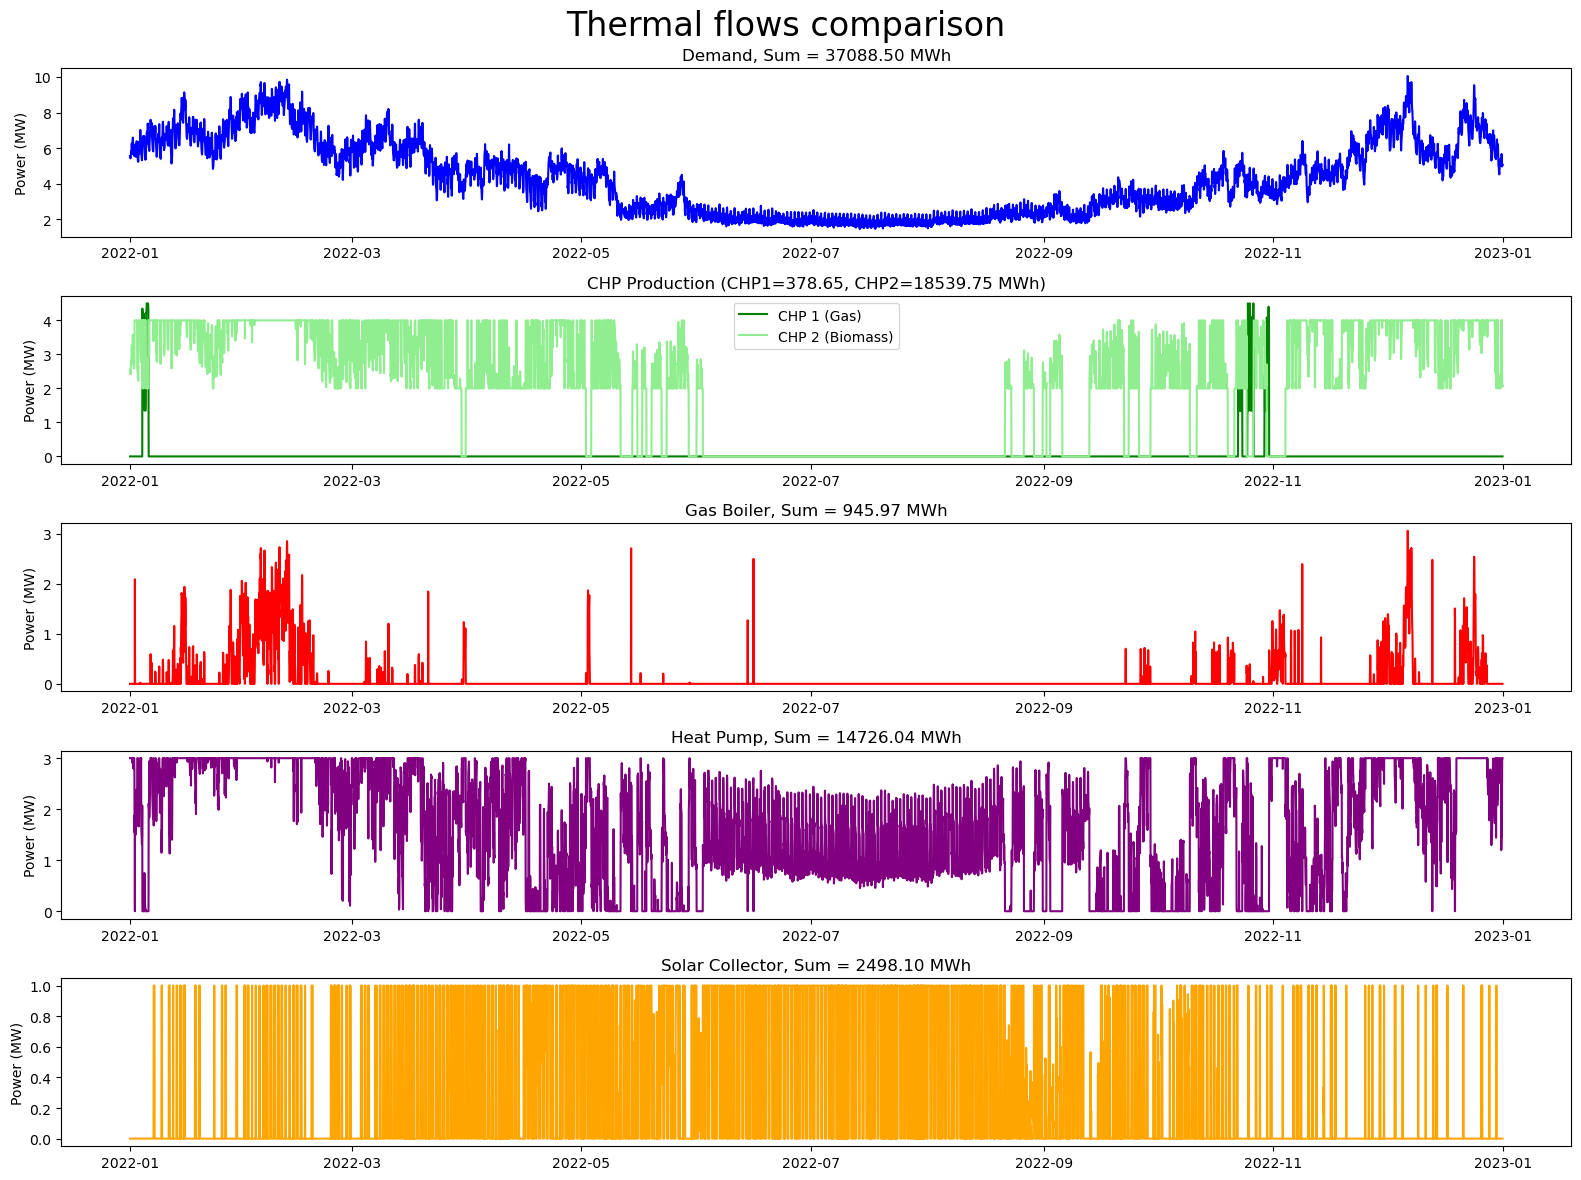

In [29]:

Sum_th_demand = thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand_with_losses'), 'flow')].sum()
Sum_th_prod_chp1 = thermal_bus_node["sequences"][(('chp_1', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_chp2 = thermal_bus_node["sequences"][(('chp_2', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_boiler = thermal_bus_node["sequences"][(('gas_boiler_1', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_hp = thermal_bus_node["sequences"][(('heat_pump', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_sc = thermal_bus_node["sequences"][(('solar_collector', 'thermal_bus'), 'flow')].sum()

fig, axs = plt.subplots(5, figsize=(16, 12)) 
fig.suptitle('Thermal flows comparison', fontsize=24)

# 1. Demand
axs[0].plot(thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand_with_losses'), 'flow')], 'blue')
axs[0].set_title(f'Demand, Sum = {Sum_th_demand:.2f} MWh')
axs[0].set_ylabel('Power (MW)')

# 2. CHPs
axs[1].plot(thermal_bus_node["sequences"][(('chp_1', 'thermal_bus'), 'flow')], 'green', label='CHP 1 (Gas)')
axs[1].plot(thermal_bus_node["sequences"][(('chp_2', 'thermal_bus'), 'flow')], 'lightgreen', label='CHP 2 (Biomass)')
axs[1].set_title(f'CHP Production (CHP1={Sum_th_prod_chp1:.2f}, CHP2={Sum_th_prod_chp2:.2f} MWh)')
axs[1].legend()
axs[1].set_ylabel('Power (MW)')

# 3. Gas Boiler
axs[2].plot(thermal_bus_node["sequences"][(('gas_boiler_1', 'thermal_bus'), 'flow')], 'red')
axs[2].set_title(f'Gas Boiler, Sum = {Sum_th_prod_boiler:.2f} MWh')
axs[2].set_ylabel('Power (MW)')

# 4. Heat Pump
axs[3].plot(thermal_bus_node["sequences"][(('heat_pump', 'thermal_bus'), 'flow')], 'purple')
axs[3].set_title(f'Heat Pump, Sum = {Sum_th_prod_hp:.2f} MWh')
axs[3].set_ylabel('Power (MW)')

# 5. Solar Collector
axs[4].plot(thermal_bus_node["sequences"][(('solar_collector', 'thermal_bus'), 'flow')], 'orange')
axs[4].set_title(f'Solar Collector, Sum = {Sum_th_prod_sc:.2f} MWh')
axs[4].set_ylabel('Power (MW)')

plt.tight_layout()
plt.show()

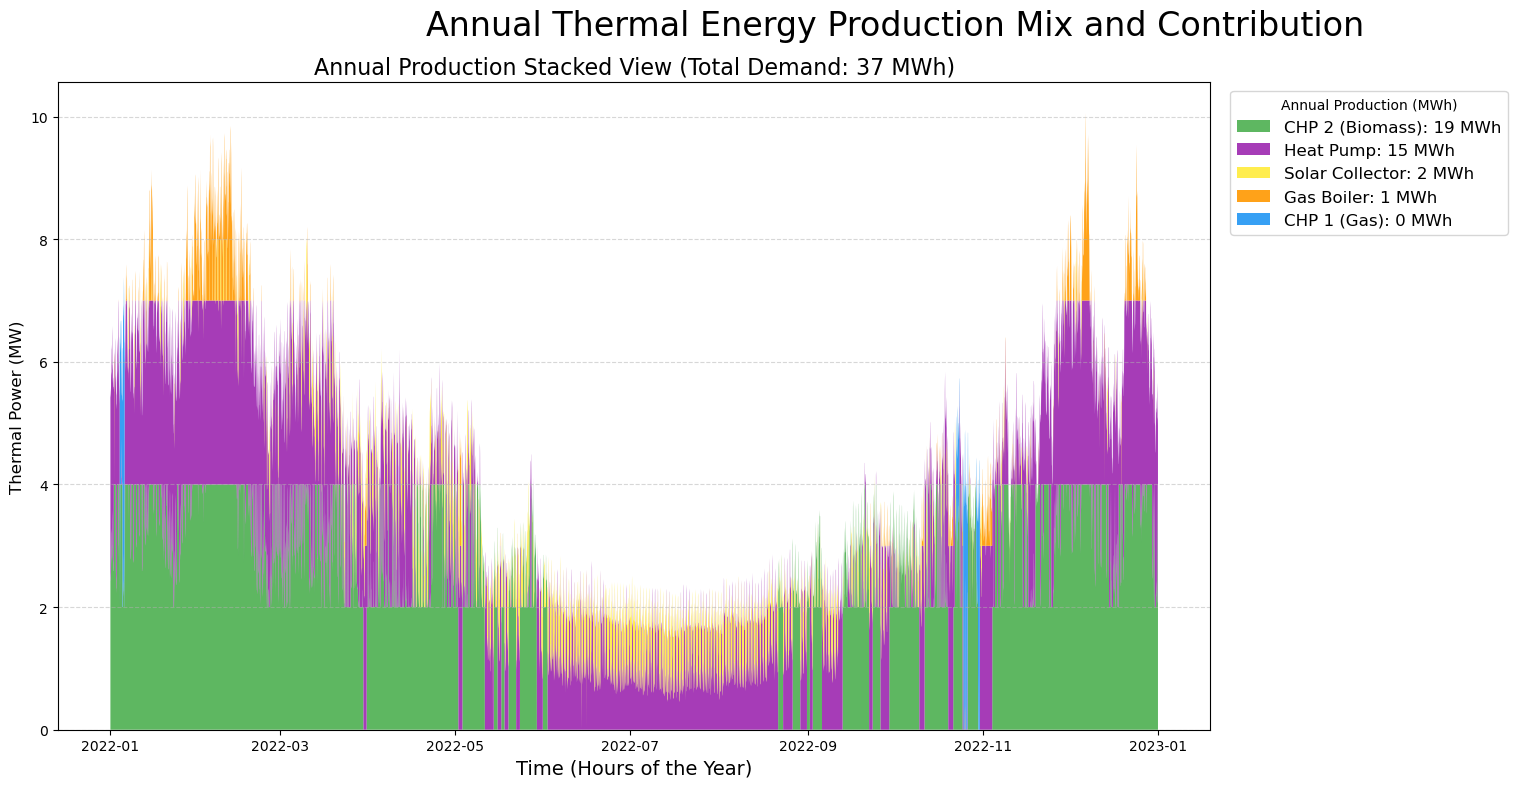

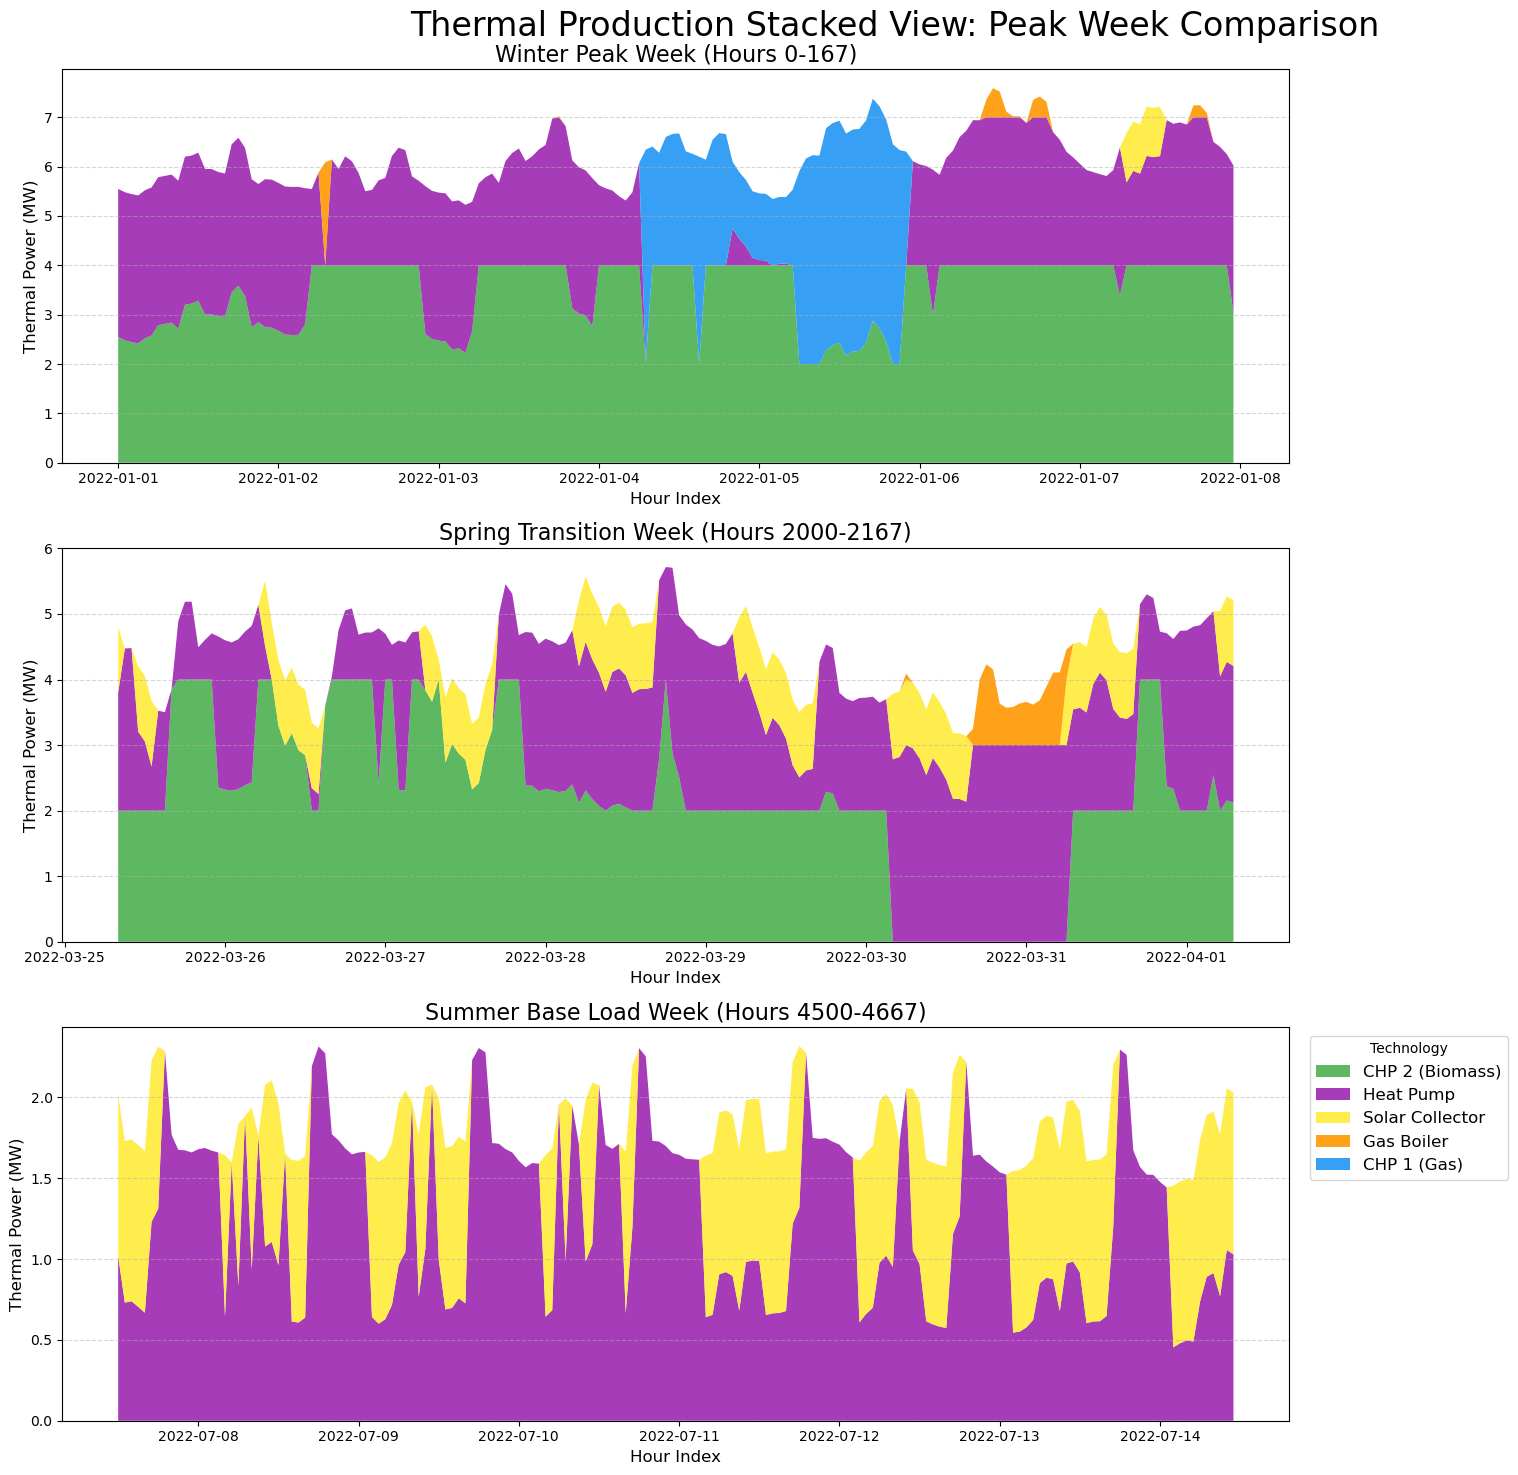


--- Summary of Thermal Production (MWh) ---
- CHP 2 (Biomass) (Color: #4CAF50): 19 MWh
- Heat Pump (Color: #9C27B0): 15 MWh
- Solar Collector (Color: #FFEB3B): 2 MWh
- Gas Boiler (Color: #FF9800): 1 MWh
- CHP 1 (Gas) (Color: #2196F3): 0 MWh

Sorting Order (Bottom of Stack to Top):
  5. CHP 1 (Gas)
  4. Gas Boiler
  3. Solar Collector
  2. Heat Pump
  1. CHP 2 (Biomass)


In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# --- ASSUMPTIONS ---
# We assume 'thermal_bus_node' is a dictionary containing the results from 
# views.node(results, "thermal_bus") with kW time series data.
# Component keys are assumed to be: 'chp_1', 'chp_2', 'gas_boiler_1', 'heat_pump', 'solar_collector'.

# 1. Define the components, their data keys, and preferred colors
component_data = {
    'CHP 1 (Gas)':         {'key': (('chp_1', 'thermal_bus'), 'flow'),          'color': '#2196F3'},  # Blue for Gas
    'CHP 2 (Biomass)':     {'key': (('chp_2', 'thermal_bus'), 'flow'),          'color': '#4CAF50'},  # Green for Biomass
    'Gas Boiler':          {'key': (('gas_boiler_1', 'thermal_bus'), 'flow'),   'color': '#FF9800'},  # Orange for Peak Gas Boiler
    'Heat Pump':           {'key': (('heat_pump', 'thermal_bus'), 'flow'),      'color': '#9C27B0'},  # Purple for HP
    'Solar Collector':     {'key': (('solar_collector', 'thermal_bus'), 'flow'), 'color': '#FFEB3B'},  # Yellow for Solar
}

# 2. Extract time series data and calculate annual sums
production_df = pd.DataFrame()
total_annual_production = {}

for name, data in component_data.items():
    # Retrieve the time series and ensure it's a pandas Series
    timeseries = thermal_bus_node["sequences"][data['key']]
    
    # Store the time series data (assumed in kW)
    production_df[name] = timeseries
    
    # Calculate the total annual energy (kWh), and store in MWh for display
    total_annual_production[name] = timeseries.sum() / 1000 # Sum (kW) = kWh, /1000 = MWh

# 3. Sort the components by total annual production (MWh) from LARGEST to SMALLEST
# The largest producer must be the first series in the list to form the base of the stack.
sorted_components = sorted(
    total_annual_production.items(), 
    key=lambda item: item[1], 
    reverse=True # TRUE places the LARGEST producer first (at the bottom of the stack)
)

# 4. Prepare data lists for stackplot in the sorted order
labels_sorted = [comp[0] for comp in sorted_components]
colors_sorted = [component_data[name]['color'] for name in labels_sorted]
series_sorted = [production_df[name] for name in labels_sorted]

# Calculate the total demand for the title comparison (in MWh)
Sum_th_demand_MWh = thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand_with_losses'), 'flow')].sum() / 1000


# --- Plotting Function ---
def plot_stacked_production(ax, title, x_data, y_series, colors, labels):
    """Generates a single stacked area plot with boundaries."""
    
    # 1. Generate the Stacked Area Plot (filled areas)
    ax.stackplot(
        x_data,
        y_series,
        colors=colors,
        labels=labels,
        alpha=0.9
    )

    # 2. Add Clear Boundary Separation (draw lines on top of the stack)
    # Get the cumulative sum to plot the top line of each layer
    cumulative_sum = pd.Series([0] * len(x_data), index=x_data)
    for series in y_series:
        cumulative_sum += series
        # Plot the upper boundary of the current layer
        #ax.plot(x_data, cumulative_sum, color='black', linewidth=0.5, alpha=1) 
    
    # Plot the bottom boundary (x-axis)
    #ax.axhline(0, color='black', linewidth=0.5, alpha=1)
    
    # 3. Formatting
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Thermal Power (MW)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    
# --- FIGURE 1: ANNUAL THERMAL PRODUCTION STACKED AREA CHART ---
fig1, ax1 = plt.subplots(figsize=(18, 8))
fig1.suptitle('Annual Thermal Energy Production Mix and Contribution', fontsize=24)

# Plot the annual data
plot_stacked_production(
    ax1,
    title=f'Annual Production Stacked View (Total Demand: {Sum_th_demand_MWh:,.0f} MWh)',
    x_data=production_df.index,
    y_series=series_sorted,
    colors=colors_sorted,
    labels=labels_sorted
)

# Custom legend with MWh totals
legend_handles = []
custom_labels = []
for name in labels_sorted:
    mwh_sum = total_annual_production[name]
    custom_labels.append(f"{name}: {mwh_sum:,.0f} MWh")
    legend_handles.append(
        plt.Rectangle((0, 0), 1, 1, fc=component_data[name]['color'], alpha=0.9)
    )

ax1.legend(legend_handles, 
           custom_labels, 
           loc='upper left', 
           bbox_to_anchor=(1.01, 1), 
           title="Annual Production (MWh)",
           fontsize=12)

ax1.set_xlabel('Time (Hours of the Year)', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- FIGURE 2: PEAK WEEK COMPARISON (WINTER, SPRING, SUMMER) ---
fig2, axs2 = plt.subplots(3, 1, figsize=(18, 15), sharex=False)
fig2.suptitle('Thermal Production Stacked View: Peak Week Comparison', fontsize=24)

# Define peak week time slices (assuming 8760 hours/year)
# Note: The indices are pandas row indices, not necessarily the actual date time
time_slices = {
    'Winter Peak Week (Hours 0-167)':       (0, 168),      # Start of year (January)
    'Spring Transition Week (Hours 2000-2167)': (2000, 2168),  # Late March/Early April
    'Summer Base Load Week (Hours 4500-4667)':  (4500, 4668)   # Mid-July
}

for i, (period_title, (start, end)) in enumerate(time_slices.items()):
    ax = axs2[i]
    
    # Slice the data for the specific week
    sliced_series = [s.iloc[start:end] for s in series_sorted]
    sliced_x_data = production_df.index[start:end]
    
    plot_stacked_production(
        ax,
        title=period_title,
        x_data=sliced_x_data,
        y_series=sliced_series,
        colors=colors_sorted,
        labels=labels_sorted
    )
    ax.set_xlabel('Hour Index', fontsize=12) # Use index for simplicity

# Add legend to the bottom plot only
axs2[2].legend(legend_handles, 
               labels_sorted,
               loc='upper left', 
               bbox_to_anchor=(1.01, 1), 
               title="Technology",
               fontsize=12)
    
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# --- PRINT SUMMARY FOR CONTEXT ---
print("\n--- Summary of Thermal Production (MWh) ---")
for name, mwh in sorted(total_annual_production.items(), key=lambda item: item[1], reverse=True):
    print(f"- {name} (Color: {component_data[name]['color']}): {mwh:,.0f} MWh")

print(f"\nSorting Order (Bottom of Stack to Top):")
for i, name in enumerate(labels_sorted[::-1]):
    print(f"  {len(labels_sorted) - i}. {name}")

### Analyse storage node

In [31]:
# # Analyse storage node
# # Check if storage exists in the energy system
# if storage and 'sequences' in storage:
#     Sum_storage_Outflow = storage['sequences'][(('storage', 'thermal_bus'), 'flow')].sum()
#     Sum_storage_Inflow = storage['sequences'][(('thermal_bus', 'storage'), 'flow')].sum()
# else:
#     print("No storage component found in the energy system. Skipping storage analysis.")
#     Sum_storage_Outflow = 0
#     Sum_storage_Inflow = 0

# fig, ax = plt.subplots(figsize=(16, 9))
# storage['sequences'][(('thermal_bus', 'storage'), 'flow')].plot(
#     ax=ax, kind="line", drawstyle="steps-post",color="green"
# )
# plt.legend(
#     loc="upper right"
# )
# fig.subplots_adjust(top=0.8)
# fig.suptitle(f'Storage inflow, Sum = {int(Sum_storage_Inflow / 1000)} MWh', fontsize=24)
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots(figsize=(16, 9))
# storage['sequences'][(('storage', 'thermal_bus'), 'flow')].plot(
#     ax=ax, kind="line", drawstyle="steps-post",color="blue"
# )
# plt.legend(
#     loc="upper right"
# )
# fig.subplots_adjust(top=0.8)
# fig.suptitle(f'Storage outflow, Sum = {int(Sum_storage_Outflow / 1000)} MWh', fontsize=24)
# plt.show()

# fig, ax = plt.subplots(figsize=(16, 9))
# storage['sequences'][(('storage', 'None'), 'storage_content')].plot(
#     ax=ax, kind="line", drawstyle="steps-post",color="orange"
# )
# plt.legend(
#     loc="upper right"
# )
# fig.subplots_adjust(top=0.8)
# fig.suptitle('Storage content', fontsize=24)
# plt.tight_layout()
# plt.show()

In [32]:
# fig, axs = plt.subplots(3,figsize=(16, 9))
# fig.suptitle('Comparison of storage flows and content', fontsize=24)
# axs[0].plot(storage['sequences'][(('thermal_bus', 'storage'), 'flow')], 'green')
# axs[0].set_title(f'Storage inflow, Sum = {int(Sum_storage_Inflow / 1000)} MWh')
# axs[1].plot(storage['sequences'][(('storage', 'thermal_bus'), 'flow')], 'blue')
# axs[1].set_title(f'Storage outflow, Sum = {int(Sum_storage_Outflow / 1000)} MWh')
# axs[2].plot(storage['sequences'][(('storage', 'None'), 'storage_content')], 'orange')
# axs[2].set_title('Storage content')

# axs[0].set_ylabel('Power in kW')
# axs[1].set_ylabel('Power in kW')
# axs[2].set_ylabel('Content in kWh')

# plt.tight_layout()
# plt.show()

In [33]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # --- ASSUMPTIONS ---
# # We assume 'thermal_bus_node' is a dictionary containing the results from 
# # views.node(results, "thermal_bus") with kW time series data.
# # Component keys are assumed to be: 'chp_1', 'chp_2', 'gas_boiler_1', 'heat_pump', 'solar_collector'.

# # 1. Define the components, their data keys, and preferred colors
# component_data = {
#     'CHP 1 (Gas)':         {'key': (('chp_1', 'thermal_bus'), 'flow'),          'color': '#2196F3'},  # Blue for Gas
#     'CHP 2 (Biomass)':     {'key': (('chp_2', 'thermal_bus'), 'flow'),          'color': '#4CAF50'},  # Green for Biomass
#     'Gas Boiler':          {'key': (('gas_boiler_1', 'thermal_bus'), 'flow'),   'color': '#FF9800'},  # Orange for Peak Gas Boiler
#     'Heat Pump':           {'key': (('heat_pump', 'thermal_bus'), 'flow'),      'color': '#9C27B0'},  # Purple for HP
#     'Solar Collector':     {'key': (('solar_collector', 'thermal_bus'), 'flow'), 'color': '#FFEB3B'},  # Yellow for Solar
# }

# # 2. Extract time series data and calculate annual sums
# production_df = pd.DataFrame()
# total_annual_production = {}

# for name, data in component_data.items():
#     # Retrieve the time series and ensure it's a pandas Series
#     timeseries = thermal_bus_node["sequences"][data['key']]
    
#     # Store the time series data (assumed in kW)
#     production_df[name] = timeseries
    
#     # Calculate the total annual energy (kWh), and store in MWh for display
#     total_annual_production[name] = timeseries.sum() / 1000 # Sum (kW) = kWh, /1000 = MWh

# # 3. Sort the components by total annual production (MWh) from LARGEST to SMALLEST
# # The largest producer must be the first series in the list to form the base of the stack.
# sorted_components = sorted(
#     total_annual_production.items(), 
#     key=lambda item: item[1], 
#     reverse=True # TRUE places the LARGEST producer first (at the bottom of the stack)
# )

# # 4. Prepare data lists for stackplot in the sorted order
# labels_sorted = [comp[0] for comp in sorted_components]
# colors_sorted = [component_data[name]['color'] for name in labels_sorted]
# series_sorted = [production_df[name] for name in labels_sorted]

# # Calculate the total demand for the title comparison (in MWh)
# Sum_th_demand_MWh = thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand_with_losses'), 'flow')].sum() / 1000


# # --- Plotting Function ---
# def plot_stacked_production(ax, title, x_data, y_series, colors, labels):
#     """Generates a single stacked area plot with boundaries."""
    
#     # 1. Generate the Stacked Area Plot (filled areas)
#     ax.stackplot(
#         x_data,
#         y_series,
#         colors=colors,
#         labels=labels,
#         alpha=0.9
#     )

#     # 2. Add Clear Boundary Separation (draw lines on top of the stack)
#     # Get the cumulative sum to plot the top line of each layer
#     cumulative_sum = pd.Series([0] * len(x_data), index=x_data)
#     for series in y_series:
#         cumulative_sum += series
#         # Plot the upper boundary of the current layer
#         #ax.plot(x_data, cumulative_sum, color='black', linewidth=0.5, alpha=1) 
    
#     # Plot the bottom boundary (x-axis)
#     ax.axhline(0, color='black', linewidth=0.5, alpha=1)
    
#     # 3. Formatting
#     ax.set_title(title, fontsize=16)
#     ax.set_ylabel('Thermal Power (kW)', fontsize=12)
#     ax.grid(axis='y', linestyle='--', alpha=0.5)

    
# # --- FIGURE 1: ANNUAL THERMAL PRODUCTION STACKED AREA CHART ---
# fig1, ax1 = plt.subplots(figsize=(18, 8))
# fig1.suptitle('Annual Thermal Energy Production Mix and Contribution', fontsize=24)

# # Plot the annual data
# plot_stacked_production(
#     ax1,
#     title=f'Annual Production Stacked View (Total Demand: {Sum_th_demand_MWh:,.0f} MWh)',
#     x_data=production_df.index,
#     y_series=series_sorted,
#     colors=colors_sorted,
#     labels=labels_sorted
# )

# # Custom legend with MWh totals
# legend_handles = []
# custom_labels = []
# for name in labels_sorted:
#     mwh_sum = total_annual_production[name]
#     custom_labels.append(f"{name}: {mwh_sum:,.0f} MWh")
#     legend_handles.append(
#         plt.Rectangle((0, 0), 1, 1, fc=component_data[name]['color'], alpha=0.9)
#     )

# ax1.legend(legend_handles, 
#            custom_labels, 
#            loc='upper left', 
#            bbox_to_anchor=(1.01, 1), 
#            title="Annual Production (MWh)",
#            fontsize=12)

# ax1.set_xlabel('Time (Hours of the Year)', fontsize=14)
# plt.tight_layout(rect=[0, 0, 0.85, 1])
# plt.show()


# # --- FIGURE 2: PEAK WEEK COMPARISON (WINTER, SPRING, SUMMER) ---
# fig2, axs2 = plt.subplots(3, 1, figsize=(18, 15), sharex=False)
# fig2.suptitle('Thermal Production Stacked View: Peak Week Comparison', fontsize=24)

# # Define peak week time slices (assuming 8760 hours/year)
# # Note: The indices are pandas row indices, not necessarily the actual date time
# time_slices = {
#     'Winter Peak Week (Hours 0-167)':       (0, 168),      # Start of year (January)
#     'Spring Transition Week (Hours 2000-2167)': (2000, 2168),  # Late March/Early April
#     'Summer Base Load Week (Hours 4500-4667)':  (4500, 4668)   # Mid-July
# }

# for i, (period_title, (start, end)) in enumerate(time_slices.items()):
#     ax = axs2[i]
    
#     # Slice the data for the specific week
#     sliced_series = [s.iloc[start:end] for s in series_sorted]
#     sliced_x_data = production_df.index[start:end]
    
#     plot_stacked_production(
#         ax,
#         title=period_title,
#         x_data=sliced_x_data,
#         y_series=sliced_series,
#         colors=colors_sorted,
#         labels=labels_sorted
#     )
#     ax.set_xlabel('Hour Index', fontsize=12) # Use index for simplicity

# # Add legend to the bottom plot only
# axs2[2].legend(legend_handles, 
#                labels_sorted,
#                loc='upper left', 
#                bbox_to_anchor=(1.01, 1), 
#                title="Technology",
#                fontsize=12)
    
# plt.tight_layout(rect=[0, 0, 0.85, 1])
# plt.show()

# # --- PRINT SUMMARY FOR CONTEXT ---
# print("\n--- Summary of Thermal Production (MWh) ---")
# for name, mwh in sorted(total_annual_production.items(), key=lambda item: item[1], reverse=True):
#     print(f"- {name} (Color: {component_data[name]['color']}): {mwh:,.0f} MWh")

# print(f"\nSorting Order (Bottom of Stack to Top):")
# for i, name in enumerate(labels_sorted[::-1]):
#     print(f"  {len(labels_sorted) - i}. {name}")

In [34]:
total_cost = model.objective()

results = processing.convert_keys_to_strings(processing.results(model))

annual_heat = results[("thermal_bus", "thermal_demand_with_losses")]["sequences"]["flow"].sum()
average_heat_cost = total_cost / annual_heat

print(f"Annual heat supplied: {annual_heat:,.2f} MWh_th")
print(f"Total annual system cost: {total_cost:,.2f} EUR")
print(f"Average heat cost: {average_heat_cost:,.2f} EUR/MWh_th")


Annual heat supplied: 37,088.50 MWh_th
Total annual system cost: 903,816.98 EUR
Average heat cost: 24.37 EUR/MWh_th


In [35]:
res = processing.convert_keys_to_strings(processing.results(model))

gas_in_chp1 = res[("gas_bus", "chp_1")]["sequences"]["flow"].sum()
gas_in_boiler = res[("gas_bus", "gas_boiler_1")]["sequences"]["flow"].sum()
gas_total = gas_in_chp1 + gas_in_boiler

emissions_gas_t = gas_total * EF_GAS
print(f"Total gas consumption: {gas_total:,.2f} MWh_fuel")
print(f"Total CO2 emissions from gas: {emissions_gas_t:,.2f} tCO2")


Total gas consumption: 1,837.20 MWh_fuel
Total CO2 emissions from gas: 371.12 tCO2
